# Обработка результатов эксперимента: Спектральные приботы.

## Лабораторная работа №4.4.2: Фазовая дифракционная решетка (эшелет).

Необходимые импорты:

In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy import stats
from IPython.display import display, Math, Markdown

Параметры эшелета:

In [22]:
lamb_p = 500 # нм
m_p = 1 # рабочий порядок

### I. Исследование спектра ртутной лампы.

Измерения:

In [23]:
data = pd.read_excel('4.4.2.measurements.xlsx', sheet_name='Hg lamp speck')

# Данные записаны как: четыре стобца -- "имя" линии, град, мин, сек. Строка с именем 0 соотвествует началу отсчета.
# Остальные линии имеют имена: 1 - левая желтая, 2 - правая желтая
# 3 - зеленая, 4 - голубая, 5 - синяя, 6 - фиолетовая
# К1 - левая красная, К2 - правая красная
# прим. смотри спектр ртутной лампы.

deg = data['grad']
mins = data['mins']
sec = data['sec']


# Уголвые координаты спектральных линий ртути в рабочем порядке (m = 1).
total_angle = np.array([np.radians((deg[i] - deg[0] - 90) + 1 / 60 * (mins[i] - mins[0]) + 1 / 3600 * (sec[i] - sec[0])) for i in range(1, len(deg))]) # рад.

# Табличные значения длин волн спектральных линий ртути.
lamb = [579.1, 577.0, 546.1, 491.6, 435.8, 404.7, 623.4, 690.7] # нм.
# ВАЖНОЕ ЗАМЕЧЕНИЕ: здесь и далее использован порядок спектральных линий в соответствие с именами:
# 1, 2, 3, 4, 5, 6, K2, K1

#Ошибка определения угол гониометром:
gon_err_s = 15 #sec
gon_err = np.radians(1/ 360 * gon_err_s) # рад.
# т.к. угол в десятую секунды мал, то погрешность синуса примерно тоже равна gon_err -- это будет использовано далее.

# Угол падения на эшелет
psi = np.radians(45) # рад.


$\textbf{Замечание:} $ заявленная приборная погрешность гониометра: не более 5 секунд, но в силу статистической обработки погрешностей (см. ниже) и неминуемой погрешности глаза экспериментатора, погрешность отсчета углов гониметром в этой работе составляет 15 секунд. 

1. Определение периода эшелета:

Строим график: $(\sin{\varphi_m} - \sin{\psi}) = \frac{m}{d}\lambda$, где $\psi = 45^{\circ}, m = m_p = 1$ и аппроксимируем его с помощью curve_fit функцией $y = 1/d \cdot x + b$, где $b -$  параметр, зависящий от начала отсчета углов, фиксированный на протяжении все работы, поэтому не участвует в рассмотрении.

In [24]:
def f(x, k, b):
    return 1/k * x + b

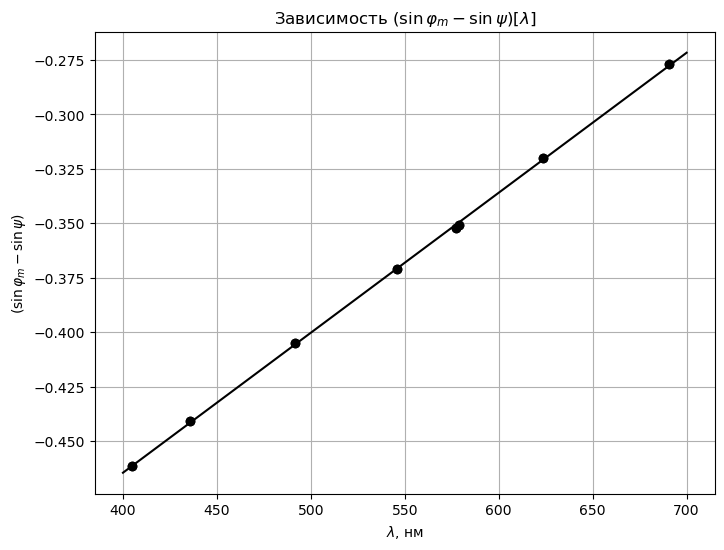

Искомый период решетки:

<IPython.core.display.Math object>

In [25]:
x = lamb
y = np.sin(total_angle) - np.sin(psi)

sigma = np.array([gon_err] * len(x))

popt, pcov = curve_fit(f, x, y, sigma=sigma)

plt.figure(figsize =(8, 6))

plt.plot(np.linspace(400, 700, 10), f(np.linspace(400, 700, 10), *popt), color=(0,0,0))
plt.scatter(x, y, marker='o', color=(0,0,0))
plt.errorbar(x, y, yerr = sigma, color=(0,0,0), fmt='o')
plt.xlabel(r'$\lambda$, нм')
plt.ylabel(r'$(\sin{\varphi_m} - \sin{\psi})$')
plt.title(r'Зависимость $(\sin{\varphi_m} - \sin{\psi})[\lambda]$')

plt.grid()
plt.show()


k = popt[0]
sigma_k = np.sqrt(pcov[0,0])

display(Markdown(r'Искомый период решетки:'))
display(Math(r'd = %.0f \pm %.0f \text{ нм}' % (k, sigma_k)))

Анализ суммы хи-квадрат

In [26]:
def Chi2(f, k, b, x, y):
    return np.sum([((y[i] - f(x[i], k, b)) / sigma[i]) ** 2 for i in range(len(x))])

In [27]:
_chi2 = lambda p: Chi2(f, p, popt[1], x, y)
minCHI2 = _chi2(k)
doF = len(x) - 1
CHI2_doF = minCHI2 / doF
display(Markdown(r'Сумма хи-квадрат, нормированная на число степеней свободы:'))
display(Math(r'\chi^2/d_f = %.2f' % CHI2_doF))
display(Markdown(r'Вероятность того, что отклонения от модельной функции случайны:'))
display(Markdown(r'$$P_{\rm err} = %.1f%s$$ ' % 
                 (stats.chi2.sf(minCHI2, doF) * 100, "\%")))

Сумма хи-квадрат, нормированная на число степеней свободы:

<IPython.core.display.Math object>

Вероятность того, что отклонения от модельной функции случайны:

$$P_{\rm err} = 10.5\%$$ 

$P_{err} > 5\% \longrightarrow $ аппроксимацию считаем удовлетворительной.

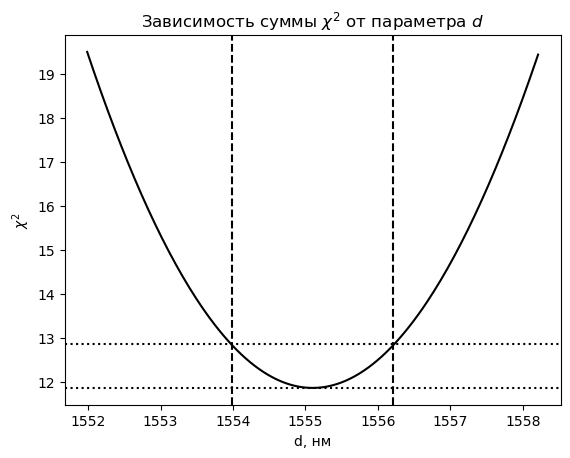

Период эшелета (с погрешностью по уровню значимости $P=0{,}68$):

<IPython.core.display.Math object>

In [28]:
LEVEL = 1
_sk = 0.002 * k # ширина анализируемого интервала
NK = 200 # число точек
_K = np.linspace(k - _sk, k + _sk, NK)
CHI2 = np.array([_chi2(_k) for _k in _K])

lS = rS = 0
# левая граница
for i in range(len(_K)):
    if CHI2[i] <= minCHI2 + LEVEL:
        lS = k - _K[i]
        break
# правая граница
for i in range(len(_K) - 1, 0, -1):
    if CHI2[i] <= minCHI2 + LEVEL:
        rS = _K[i] - k
        break

plt.axhline(y = minCHI2, color=(0,0,0),linestyle=':')
plt.axhline(y = minCHI2 + LEVEL, color=(0,0,0), linestyle=':')
plt.axvline(x = k - lS, color=(0,0,0),linestyle='--')
plt.axvline(x = k + rS, color=(0,0,0),linestyle='--')
plt.plot(_K, CHI2, color=(0,0,0))
plt.ylabel(r"$\chi^2$")
plt.xlabel(r"d, нм")
plt.title(r"Зависимость суммы $\chi^2$ от параметра $d$")
plt.show()

display(Markdown(r'Период эшелета (с погрешностью по уровню значимости $P=0{,}68$):'))
display(Math(r'd = %.0f\,^{+\,%.0f}_{-%.0f}\;\text{нм.}' % (k, lS, rS)))

2. Рассчет угла скоса рабочей грани эшелета:

Проведем рассчет по формуле: $2d\sin{\Omega} = m_p \lambda_p$

In [29]:
Omega = np.arcsin(m_p * lamb_p / (2 * k))
sigma_Omega = 1 / (np.sqrt(1 - (m_p * lamb_p / (2 * k)) ** 2)) * m_p * lamb_p / (2 * k ** 2) * 1


display(Math(r'\Omega = (%.2f \pm %.2f)^{\circ}' % (np.rad2deg(Omega), np.rad2deg(sigma_Omega))))

<IPython.core.display.Math object>

3. Качественная оценка аппаратной разрешающей способности системы (эшелет-гониометр-глаз)

Для этого измерим ширину одной из желтых линий спектра и на глаз определим во сколько раз расстояние между линиями желтого дуплета больше полуширины линии и произведем рассчет по формулам:

$R_{est} = \frac{\lambda}{\Delta \lambda},\;\frac{w}{\Delta \lambda} = \frac{m}{d \cos{w}},$ где $w = \frac{\Delta \varphi}{2}\;-$ полуширина полосы, $m = 1 \;-$ рабочий порядок 

In [30]:
data = pd.read_excel('4.4.2.measurements.xlsx', sheet_name='R estimation')

left = data['angle_left']
right = data['angle_right']

# Угловая координата левой границы первой желтой полосы в рад.
total_left = np.radians((left[0] - deg[0] - 90) + 1 / 60 * (left[1] - mins[0]) + 1 / 3600 * (left[2] - sec[0]))
# Угловая координата правой границы первой желтой полосы в рад.
total_right = np.radians((right[0] - deg[0] - 90) + 1 / 60 * (right[1] - mins[0]) + 1 / 3600 * (right[2] - sec[0]))

# Угловая ширина
w = abs(total_right - total_left) / 2

# Во сколько раз расстояние между полосами больше полуширины линии
delta = 20

delta_lamb = w * k * np.cos(w) * delta

display(Math(r'w = %.7f рад.' %w))
display(Math(r'\delta = %0.f' %delta))
display(Math(r'\Delta \lambda = %.1f нм' %delta_lamb))


display(Math(r'R_{est} = \frac{\lambda}{\Delta \lambda} = %.0f' % (lamb[0]/delta_lamb)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### II. Зависимость дисперсии от угла падения в разных порядках.

1. Рассчет теоретической угловой дисперсии в рабочем по формуле $D^{theory}_p(\psi) = \frac{m_p}{\sqrt{d^2 - (m_p\lambda_p + d \sin{\psi})^2}}$

In [31]:
lamb_d = lamb[1]
def D_calc(m, psi):
    return abs(m / (np.sqrt(abs((k * 10) ** 2 - (m * (lamb_d * 10) + (k * 10) * np.sin(np.radians(psi))) ** 2)))) * np.rad2deg(1) * 3600

In [32]:
display(Math(r'|D^{theory}_{-1} (30^{\circ})| = %.1f\;\frac{угл.с}{А}' %D_calc(-1, 30)))
display(Math(r'|D^{theory}_1 (30^{\circ})| = %.1f\;\frac{угл.с}{А}' %D_calc(1, 30)))
display(Math(r'|D^{theory}_{-1} (45^{\circ})| = %.1f\;\frac{угл.с}{А}' %D_calc(-1, 45)))
display(Math(r'|D^{theory}_1 (45^{\circ})| = %.1f\;\frac{угл.с}{А}' %D_calc(1, 45)))
display(Math(r'|D^{theory}_1 (60^{\circ})| = %.1f\;\frac{угл.с}{А}' %D_calc(1, 60)))
display(Math(r'|D^{theory}_2 (60^{\circ})| = %.1f\;\frac{угл.с}{А}' %D_calc(2, 60)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

2. Рассчет значений угловой дисперсии для всех измерений:

Работа с измерениями:

In [33]:
data = pd.read_excel('4.4.2.measurements.xlsx', sheet_name='Dispersion measurements')

#Угол падения 30 градусов
m30 = data['m30']
deg30 = data['deg30']
min30 = data['min30']
sec30 = data['sec30']
total_sec_angle_30 = np.array([(deg30[i] * 3600 + min30[i] * 60 + sec30[i]) for i in range(len(m30))]) # перевод углов в секунды

#Угол падения 45 градусов
m45 = data['m45']
deg45 = data['deg45']
min45 = data['min45']
sec45 = data['sec45']
total_sec_angle_45 = np.array([(deg45[i] * 3600 + min45[i] * 60 + sec45[i]) for i in range(len(m45))])

#Угол падения 60 градусов
m60 = data['m60']
deg60 = data['deg60']
min60 = data['min60']
sec60 = data['sec60']
total_sec_angle_60 = np.array([(deg60[i] * 3600 + min60[i] * 60 + sec60[i]) for i in range(len(m60))])



In [34]:
dlamb = (lamb[0] - lamb[1]) * 10 # разность длин волн желтого дуплета в А.

display(Math(r'|D^{exp}_{-1} (30^{\circ})| = %.1f \pm %.1f \; \frac{угл.с.}{А}' % (abs(total_sec_angle_30[0] - total_sec_angle_30[1]) / dlamb, gon_err_s/dlamb )))
display(Math(r'|D^{exp}_{1} (30^{\circ})| = %.1f\pm %.1f\; \frac{угл.с.}{А}' % (abs(total_sec_angle_30[2] - total_sec_angle_30[3]) / dlamb, gon_err_s/dlamb )))
display(Math(r'|D^{exp}_{-1} (45^{\circ})| = %.1f\pm %.1f\; \frac{угл.с.}{А}' % (abs(total_sec_angle_45[0] - total_sec_angle_45[1]) / dlamb, gon_err_s/dlamb )))
display(Math(r'|D^{exp}_{1} (45^{\circ})| = %.1f\pm %.1f\; \frac{угл.с.}{А}' % (abs(total_sec_angle_45[3] - total_sec_angle_45[2]) / dlamb, gon_err_s/dlamb )))
display(Math(r'|D^{exp}_1 (60^{\circ})| = %.1f\pm %.1f\; \frac{угл.с.}{А}' % (abs(total_sec_angle_60[0] - total_sec_angle_60[1]) / dlamb, gon_err_s/dlamb )))
display(Math(r'|D^{exp}_2 (60^{\circ})| = %.1f\pm %.1f\; \frac{угл.с.}{А}' % (abs(total_sec_angle_60[2] - total_sec_angle_60[3]) / dlamb, gon_err_s/dlamb )))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

3. Рассчет общей угловой дисперсии эшелета:

In [35]:
av_D = 1/(3 * dlamb) * (abs(total_sec_angle_30[2] - total_sec_angle_30[3]) + abs(total_sec_angle_45[3] - total_sec_angle_45[2]) + abs(total_sec_angle_60[0] - total_sec_angle_60[1]))

display(Markdown('Средняя угловая дисперсия в рабочем порядке:'))
display(Math(r'\overline{D}^{exp}_p = %.1f \pm %.1f \frac{угл.с.}{А}' %(av_D, gon_err_s/dlamb )))

Средняя угловая дисперсия в рабочем порядке:

<IPython.core.display.Math object>

4. График зависимости угловой дисперсии от порядка для $\psi = 30^\circ$

Так как удалось "поймать" только два порядка спектров для всех углов падения, то график зависимости по двум точкам строить нецелесообразно в силу того, что он никак не будет характеризовать теоретическую зависимость. 

In [36]:
def fit_linear(x, k, b):
    return k * x + b
def theory(m):
    return m / np.sqrt(abs((k * 10) ** 2 - (m * (lamb[1] * 10) + (k * 10) * np.sin(np.radians(30))) ** 2)) * np.rad2deg(1) * 3600

C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


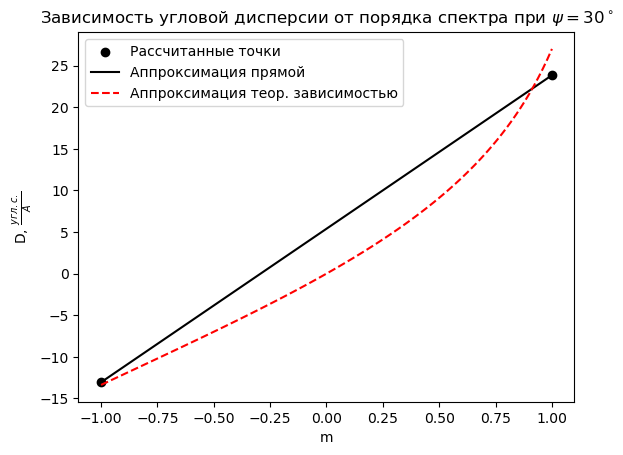

In [37]:
x = np.linspace(-1, 1, 2)
y = np.array([(total_sec_angle_30[1] - total_sec_angle_30[0]) / dlamb, (total_sec_angle_30[3] - total_sec_angle_30[2]) / dlamb])

yerr = np.array([gon_err_s/dlamb, gon_err_s/dlamb])

args_linear, sigma_linear = curve_fit(fit_linear, x, y, sigma=yerr)

plt.scatter(x, y, marker='o', color=(0,0,0), label=r'Рассчитанные точки')

plt.plot(x, fit_linear(x, *args_linear), color=(0,0,0), label=r'Аппроксимация прямой')
plt.plot(np.linspace(-1, 1, 100), theory(np.linspace(-1, 1, 100)), color=(1,0,0), linestyle='--', label=r'Аппроксимация теор. зависимостью' )

plt.title(r'Зависимость угловой дисперсии от порядка спектра при $\psi = 30^\circ$')
plt.xlabel(r'm')
plt.ylabel(r'D, $\frac{угл.с.}{А}$')

plt.legend()
plt.show()

### III. Зависимость разрешающей силы от ширины пучка.

При $\psi = 60^\circ$ подберем такую ширину диаграмы, закрепленной на объективе коллиматора, что будет наблюдаться предельная разрешимость желтого дуплета.

In [38]:
b = 1 * 100 + 30 - 60 # мкм -- минимальная ширина шели

Найдем разрешающую способность в первом порядке:

In [39]:
R = lamb[0] / (lamb[0] - lamb[1])
display(Math(r'R = %.0f' %R))
display(Math(r'R = m_p N \longrightarrow N \approx \frac{R}{1} = %0.f\;освещенных\;штрихов' %R))
display(Markdown('Коллиматор дает параллельный пучкок, значит число штрихов на мм:'))
display(Math(r'n = \frac{N}{b} \approx %.0f' % (R / (b * 10 ** (-3)))))
display(Markdown('Размер области решетки, засвеченной когерентно:'))
display(Math(r'\rho \sim \frac{b}{z} \sim \frac{b\;мкм}{10\;см} = %.0f\; нм' % (b/(10))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Коллиматор дает параллельный пучкок, значит число штрихов на мм:

<IPython.core.display.Math object>

Размер области решетки, засвеченной когерентно:

<IPython.core.display.Math object>